In [1]:
%matplotlib inline
import os
import os.path as op
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms, models

In [2]:
def setup_seed(seed):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    torch.manual_seed(seed) # 为CPU设置随机种子
    torch.cuda.manual_seed_all(seed) # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed) # 为所有GPU设置随机种子
    np.random.seed(seed) # # Numpy设置随机种子
    random.seed(seed) # Python设置随机种子
    # torch.backends.cudnn.deterministic = True
    print('Setting up seed finished!')
    
setup_seed(1)

Setting up seed finished!


In [3]:
from dataset import MNISTDataset
from model.mnist import BaseModel, Model

In [4]:
# os.makedirs('MNIST/output', exist_ok=True)
# Data
train_set = MNISTDataset(img_dir='', annot_path='train.txt', transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

valid_set = MNISTDataset(img_dir='', annot_path='valid.txt', transform=transforms.ToTensor())
valid_loader = DataLoader(dataset=valid_set, batch_size=32, shuffle=False)

test_set = MNISTDataset(img_dir='', annot_path='test.txt', transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [5]:
len(valid_set)

12000

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

Using device cuda:0


In [7]:
def train(epoch, model):
    correct = 0
    total = 0
    epoch_loss = 0.
    running_loss = 0.
    if epoch == 0:
        print(model)
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)  # 转移到cuda，且在同一块显卡上
        optimizer.zero_grad()

        # forward + backard + update
        # outputs = base_model(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        if batch_idx % 300 == 299:
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/2000))
            print(f'Accuracy on train set: {round(100*correct/total, 2)}% [{correct}/{total}]')
            running_loss = 0.0
    return epoch_loss/2000, model

In [8]:
def valid(epoch, model):
    correct = 0
    total = 0
    print('Validating...')
    with torch.no_grad():
        for data in valid_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('----------------------------------------------------------------------------')
    print(f'Accuracy on valid set: {round(100*correct/total, 2)}% [{correct}/{total}]')
    print('----------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------')

In [9]:
def eval(epoch, model):
    correct = 0
    total = 0
    print('Evaluating...')
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('----------------------------------------------------------------------------')
    print(f'Accuracy on test set: {round(100*correct/total, 2)}% [{correct}/{total}]')
    print('----------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------')

In [10]:
model = Model()
model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

epoch_loss = []
for epoch in range(10):
    current_loss, model = train(epoch, model)
    valid(epoch, model)
    epoch_loss.append(current_loss)
eval(epoch, model)

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
[1,   300] loss: 0.068
Accuracy on train set: 96.88% [31/32]
[1,   600] loss: 0.020
Accuracy on train set: 98.44% [63/64]
[1,   900] loss: 0.017
Accuracy on train set: 96.88% [93/96]
[1,  1200] loss: 0.014
Accuracy on train set: 97.66% [125/128]
[1,  1500] loss: 0.013
Accura

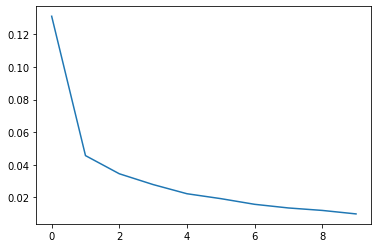

In [11]:
plt.plot(epoch_loss)

In [12]:
# don't initial parameters
model = Model(init=False)
model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

epoch_loss = []
for epoch in range(10):
    current_loss, model = train(epoch, model)
    valid(epoch, model)
    epoch_loss.append(current_loss)
eval(epoch, model)

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
[1,   300] loss: 0.063
Accuracy on train set: 90.62% [29/32]
[1,   600] loss: 0.020
Accuracy on train set: 95.31% [61/64]
[1,   900] loss: 0.014
Accuracy on train set: 94.79% [91/96]
[1,  1200] loss: 0.012
Accuracy on train set: 94.53% [121/128]
[1,  1500] loss: 0.011
Accura

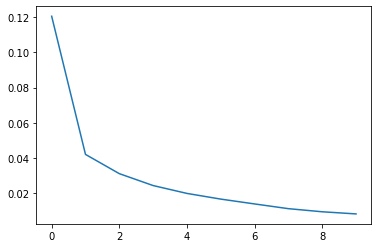

In [13]:
plt.plot(epoch_loss)

In [ ]:
base_model = BaseModel()
base_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.01, momentum=0.5)

epoch_loss = []
for epoch in range(10):
    current_loss, base_model = train(epoch, base_model)
    valid(epoch, base_model)
    epoch_loss.append(current_loss)
eval(epoch, base_model)

BaseModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)
[1,   300] loss: 0.185
Accuracy on train set: 84.38% [27/32]
[1,   600] loss: 0.047
Accuracy on train set: 85.94% [55/64]
[1,   900] loss: 0.033
Accuracy on train set: 88.54% [85/96]
[1,  1200] loss: 0.026
Accuracy on train set: 90.62% [116/128]
[1,  1500] loss: 0.023
Accuracy on train set: 92.5% [148/160]
Validating...
----------------------------------------------------------------------------
Accuracy on valid set: 95.79% [11495/12000]
----------------------------------------------------------------------------
----------------------------------------------------------------------------
[2,   300] loss: 0.019
Accuracy on train set: 93.75% [30/32]
[2,   600] loss: 0.018
Accuracy on train set: 93.75% [60/64]

In [ ]:
plt.plot(epoch_loss)